In [2]:
import autograd.numpy as np
from autograd import grad
import cvxpy as cp
import matplotlib.pyplot as plt

import pymanopt
import pymanopt.manifolds
import pymanopt.solvers
# from pymanopt.solvers import TrustRegions

from numpy.random import default_rng

import networkx as nx

from opt_utils import hyperplane_rounding, normalize_rows, eigen_proj, load_graph

In [3]:
def cost(Y):
    return -1/4 * np.trace(Y @ Y.T @ L)

In [4]:
# one iteration of elliptope optimization
def iterate_elliptope(rank, n, L, initial_Y=None):
    print("Current rank: %s"  %(rank))

    manifold = pymanopt.manifolds.Elliptope(n, rank)
    @pymanopt.function.autograd(manifold)
    def manifold_cost(Y):
        return -1/4 * np.trace(Y @ Y.T @ L)

    problem = pymanopt.Problem(manifold=manifold, cost=manifold_cost)
    solver = pymanopt.solvers.SteepestDescent(minstepsize=1e-3)
    solution = solver.solve(problem, x=initial_Y)

    return solution, manifold_cost(solution)

In [5]:
# reduce rank by optimizing over a manifold
def closest_point(Y):
    X = Y @ Y.T
    target_rank = np.linalg.matrix_rank(X, tol=1e-6) - 1
    Y_proj = Y
    if target_rank >= 2:
        manifold = pymanopt.manifolds.Elliptope(n, target_rank)
        @pymanopt.function.autograd(manifold)
        def manifold_cost(Y):
            return np.trace(Y @ Y.T @ X)

        problem = pymanopt.Problem(manifold=manifold, cost=manifold_cost)
        solver = pymanopt.solvers.SteepestDescent(minstepsize=1e-3)
        Y_proj = solver.solve(problem)

    return Y_proj, target_rank

### Data

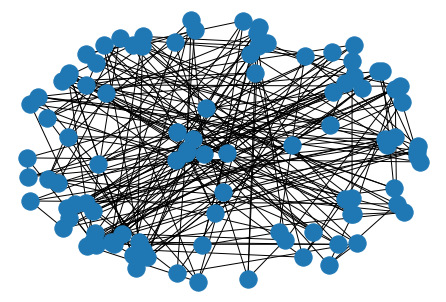

In [6]:
# graph_file = "torusg3-8.dat"
graph_file = "toruspm3-8-50.dat"

n = 100
G = load_graph(graph_file, n)

In [7]:
L = nx.laplacian_matrix(G).toarray() * 1.0

## Solve SDP relaxation

In [8]:
X = cp.Variable((n,n), PSD=True)
constraints = [ X[i][i] == 1 for i in range(n) ]
prob = cp.Problem(cp.Maximize(1/4 * (cp.trace(L @ X))), constraints)
prob.solve()

82.9970264055626

In [10]:
opt_sdp_rank = np.linalg.matrix_rank(X.value, tol=1e-9)  # the optimal solution from the original BM method paper is 33

In [12]:
sdp_solution, sdp_cost = iterate_elliptope(opt_sdp_rank, n, L)

Current rank: 10
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +3.6205330751437570e+00    9.68351629e+00    
   2         -5.9681973144626115e+00    9.55966195e+00    
   3         -3.7537780654529982e+01    7.36785876e+00    
   4         -5.1894484064142688e+01    9.19730203e+00    
   5         -7.1774642744848322e+01    4.76820179e+00    
   6         -7.6355523703926181e+01    2.22538761e+00    
   7         -7.7629975582506731e+01    3.14029501e+00    
   8         -7.8832322948535989e+01    2.47000441e+00    
   9         -7.9831730697038225e+01    1.32180491e+00    
  10         -8.0290784006840894e+01    1.32111704e+00    
  11         -8.0653349984060100e+01    1.24060551e+00    
  12         -8.0964088019522791e+01    1.03172823e+00    
  13         -8.1197412390009134e+01    1.11957118e+00    
  14         -8.1216299426569790e+01    1.77413765e+00    
  15         -8.128874530

## Manifold iteration

### Eigenprojection + hyperplane rounding

In [28]:
eigen_proj_ranks = []
eigen_proj_costs = []

rank_new = opt_sdp_rank
Y_new = None
solution_new = None
while (rank_new > 1):
    solution_new, cost_val = iterate_elliptope(rank_new, n, L, Y_new)
    eigen_proj_ranks += [rank_new]
    eigen_proj_costs += [-cost_val]
    Y_new, rank_new = eigen_proj(solution_new, True)
eigen_proj_cost, eigen_proj_solution = hyperplane_rounding(solution_new, cost)
eigen_proj_simple_rounding_cost = cost(Y_new)
eigen_proj_ranks += [1, 1]
eigen_proj_costs += [-eigen_proj_cost, -eigen_proj_simple_rounding_cost]

Current rank: 34
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +1.1350414079839648e+00    1.05042909e+01    
   2         -9.2779439585925871e+00    1.03711863e+01    
   3         -4.3522989580156782e+01    7.65467167e+00    
   4         -4.8698950170925073e+01    1.03552738e+01    
   5         -6.5861527305058601e+01    6.95866172e+00    
   6         -7.5495657587269960e+01    4.51160126e+00    
   7         -7.9282723685304205e+01    2.21437386e+00    
   8         -7.9895952259093093e+01    2.92821189e+00    
   9         -8.1288319200661988e+01    1.00509445e+00    
  10         -8.2431926611898092e+01    1.90206448e+00    
  11         -8.2488816760896142e+01    2.14383378e+00    
  12         -8.2697163833871286e+01    1.78404335e+00    
  13         -8.3164726157661192e+01    4.96449873e-01    
  14         -8.3313855134186497e+01    1.11134841e+00    
  15         -8.350999171

### Closest point + hyperplane rounding

In [29]:
closest_point_ranks = []
closest_point_costs = []

rank_new = opt_sdp_rank
Y_new = None
solution_new = None
while (rank_new > 1):
    solution_new, cost_val = iterate_elliptope(rank_new, n, L, Y_new)
    closest_point_ranks += [rank_new]
    closest_point_costs += [-cost_val]
    Y_new, rank_new = closest_point(solution_new)
closest_point_cost, closest_point_solution = hyperplane_rounding(solution_new, cost)
closest_point_ranks += [1]
closest_point_costs += [-closest_point_cost]

Current rank: 34
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         -4.7684975714960870e-01    1.04731409e+01    
   2         -1.0845821465976885e+01    1.03155174e+01    
   3         -4.4784037614788659e+01    7.57181866e+00    
   4         -5.0016655491527779e+01    1.01829539e+01    
   5         -6.7224216836808509e+01    6.71814129e+00    
   6         -7.5605323445675680e+01    4.82223708e+00    
   7         -7.7197378133755379e+01    4.80593495e+00    
   8         -8.0996349373006908e+01    1.37378316e+00    
   9         -8.1698496840406492e+01    1.74393421e+00    
  10         -8.2346592641855935e+01    9.25929980e-01    
  11         -8.2666734759651007e+01    1.02259299e+00    
  12         -8.2892898615877883e+01    9.95403224e-01    
  13         -8.3101493983003209e+01    6.96502445e-01    
  14         -8.3222922735966733e+01    1.05794268e+00    
  15         -8.339438602

## Benchmark: hyperplane rounding of SDP solution

In [30]:
_, hyperplane_rounding_cost= hyperplane_rounding(sdp_solution, cost)

## Plots

ValueError: x and y can be no greater than 2D, but have shapes (1,) and (1, 100, 1)

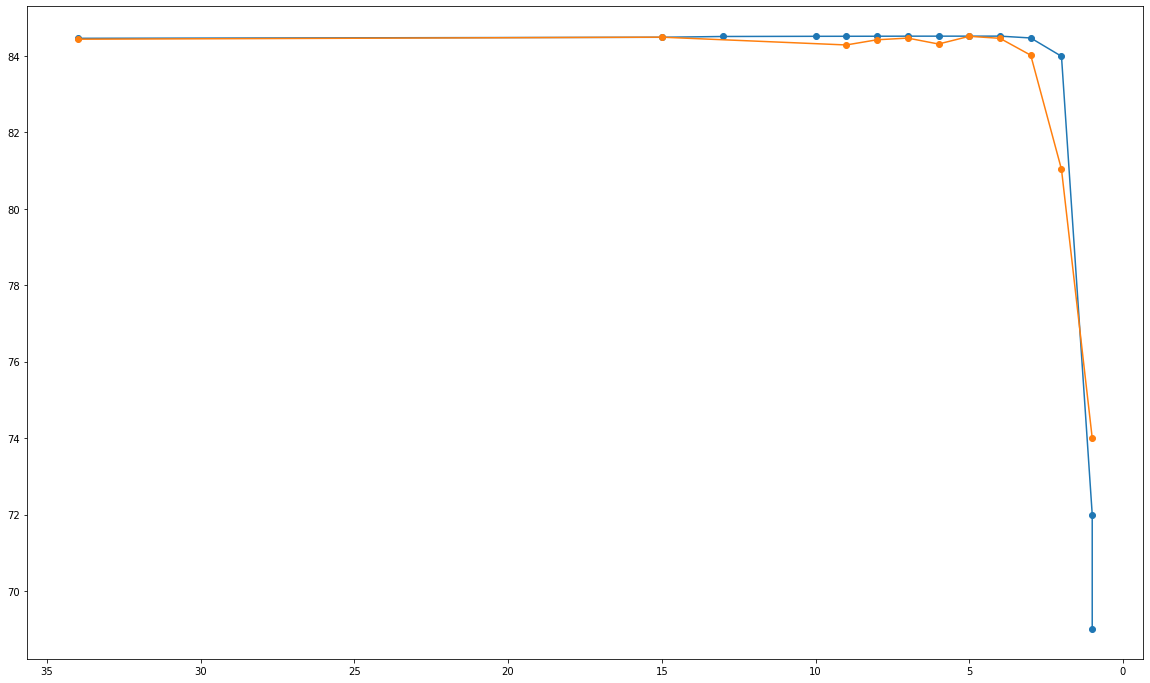

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 12)
ax.invert_xaxis()

plt.plot(eigen_proj_ranks, eigen_proj_costs, label="eigen projection", marker="o")
plt.plot(closest_point_ranks, closest_point_costs, label="closest point", marker="o")

plt.plot([1], [-hyperplane_rounding_cost], label="hyperplane rounding", marker="o")

plt.legend(loc='lower left', fontsize=22)
plt.grid()